In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline

In [2]:
tf.__version__

'2.0.1'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration( gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3700)])

### load data

In [5]:
def load_img(img,lab):
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img,tf.float32) ##???
    lab = tf.cast(lab,tf.float32)/2 #####???    turn 0,2,4 to 0,1,2 otherwise loss=NaN
    return img,lab

In [6]:
test_data=pd.read_csv('test.txt',header=None,sep=' ',names=['picture','label'])
train_data=pd.read_csv('train.txt',header=None,sep=' ',names=['picture','label'])
valid_data=pd.read_csv('valid.txt',header=None,sep=' ',names=['picture','label'])
# test_data.head()

In [7]:
test_data['dir']=[os.path.join('preprocessed','test',pic) for pic in test_data['picture']]
train_data['dir']=[os.path.join('preprocessed','train',pic) for pic in train_data['picture']]
valid_data['dir']=[os.path.join('preprocessed','valid',pic) for pic in valid_data['picture']]
# test_data.head()

In [8]:
iid_train = pd.concat([train_data[train_data['label']==i*2][:500] for i in range(3)]) #150
iid_test = pd.concat([test_data[test_data['label']==i*2][:300] for i in range(3)])   #100
iid_valid = pd.concat([valid_data[valid_data['label']==i*2][:200] for i in range(3)]) #50   or don't mind class 3, just use 0,2,4???

In [9]:
iid_train = pd.concat([iid_train,iid_test],ignore_index=True) #####################################
# iid_train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268E8D66088>]],
      dtype=object)

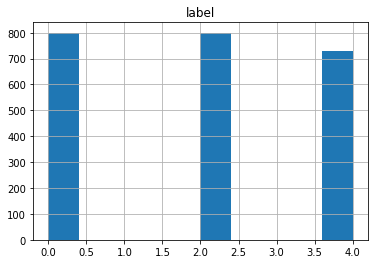

In [10]:
iid_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002688FA88A08>]],
      dtype=object)

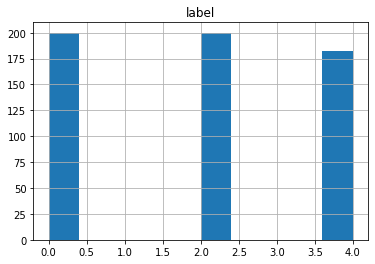

In [11]:
iid_valid.hist()

preprocessed\test\20170413114550593.jpg
0


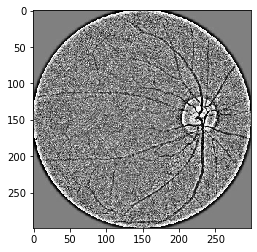

In [12]:
#show an example picture
i=9
img_path=iid_test['dir'][i]
print(img_path)
lab=iid_test['label'][i]
plt.imshow(load_img(img_path,lab)[0].numpy().squeeze(),cmap='gray')
print(lab)

In [13]:
## settings

test_LEN=len(iid_test['dir'])
valid_LEN=len(iid_valid['dir'])
train_LEN=len(iid_train['dir'])
batch_SIZE=3 ### should't be that small but my laptop....
test_EPO=int(test_LEN // batch_SIZE)
train_EPO=int(train_LEN // batch_SIZE)
valid_EPO=int(valid_LEN // batch_SIZE)

In [14]:
train_SET = tf.data.Dataset.from_tensor_slices((iid_train['dir'],iid_train['label'])).\
                            shuffle(train_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_SET = tf.data.Dataset.from_tensor_slices((iid_test['dir'],iid_test['label'])).\
#                             shuffle(test_LEN).\
#                             map(load_img).\
#                             batch(batch_SIZE).\
#                             repeat().\
#                             prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_SET = tf.data.Dataset.from_tensor_slices((iid_valid['dir'],iid_valid['label'])).\
                            shuffle(valid_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
myshape = (229,229,1)
model = tf.keras.applications.xception.Xception(include_top=True, weights=None, input_shape=myshape, classes=6)
# it said include_top should be false if input_shape is not (229,229,3), but the only difference is to add avg_pooling and prediction

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
# model.summary()

In [ ]:
epo=5
history= model.fit(train_SET,
                  epochs=epo,
                  steps_per_epoch=train_EPO,
                  validation_data=valid_SET,
                  validation_steps=valid_EPO
                  )

Train for 777 steps, validate for 194 steps
Epoch 1/5
178/777 [=====>........................] - ETA: 2:23 - loss: 1.2668 - acc: 0.3502 e+00 - ETA: 35:21 - loss: 2.2039 - - ETA: 11:21 - loss: 1.9486 - acc: - ETA: 8:32 - loss: 2.0308 - ac - ETA: 6:17 - lo - ETA: 4:16 - loss: 1. - ETA: 3:40 - loss: 1.444 - ETA: 3:21 - loss:  - ETA: 3:03 - loss: 1.341 - ETA: 2:53 - loss: 1.3264 - acc:  - ETA: 2:49 - loss: 1.3171 - acc: - ETA: 2:45 - loss: 1.3041 - - ETA: 2:39 - loss: 1.2 - ETA: 2:31 - loss: 1.2869 - acc: 0.335 - ETA: 2:31 - loss: 1.2865 - acc: 0.335 - ETA: 2:30 - loss: 1.2851 - - ETA: 2:25 - loss: 1.2769 - acc: 0

In [ ]:
# model.save_weights('myXception.h5')

# acc = history.history.get('acc')
# val_acc = history.history.get('val_acc')
# loss = history.history.get('loss')
# val_loss = history.history.get('val_loss')


# np.save("acc.npy", acc)
# np.save("val_acc.npy", val_acc)
# np.save("loss.npy", loss)
# np.save("val_loss.npy", val_loss)